#### Using neural networks to model halo-galaxy connection

- Predicting galaxy **stellar mass** given some **halo properties** using a **Neural Networks**:

#### 1) Galaxy-Halo Connection

#### 2) Libraries

In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from sklearn.metrics import mean_squared_error
import wget

#### 3) Handling data
The dataset we are going to use it's a **IllustrisTNG** box from a single snapshot (z = 0) from the **CAMELS** simulations. More information about the simulation and data is given in the CAMELS **documentation** page. 

#### 3.1) Getting and analysing the data

In [2]:
wget.download('https://www.dropbox.com/scl/fi/c7wrsplqjr5b0xwgy1cri/fof_subhalo_tab_033.hdf5?rlkey=1hve3qo7nrdh5qolesfclhlf5&st=p91k9axo&dl=0', 'data/fof_subhalo_tab_033.hdf5')

'data/fof_subhalo_tab_033 (1).hdf5'

In [4]:
with h5py.File('data/fof_subhalo_tab_033.hdf5', 'r') as f:
    print(f.keys())

<KeysViewHDF5 ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']>


The cosmological information used to run this simulation can be obtained using:

In [18]:
with h5py.File('data/fof_subhalo_tab_033.hdf5', 'r') as f:
    BoxSize         = f['Header'].attrs[u'BoxSize']/1e3
    scale_factor    = f['Header'].attrs[u'Time']   
    redshift        = f['Header'].attrs[u'Redshift']   
    h               = f['Header'].attrs[u'HubbleParam']  
    Omega_m         = f['Header'].attrs[u'Omega0']    
    Omega_L         = f['Header'].attrs[u'OmegaLambda']    

In [19]:
print('Box size: %.2f Mpc/h' %BoxSize)
print('snapshot redshift: %.2f' %redshift)
print('Omega_m: %.3f' %Omega_m)
print('Omega_L %.3f' %Omega_L)

Box size: 25.00 Mpc/h
snapshot redshift: 0.00
Omega_m: 0.300
Omega_L 0.700


Getting the properties of the **Groups** (contains the properties of the halos) and the **Subhalos** (contains properties of the subhalos, like galaxies, that are considered as subhalos with stellar mass larger than 0).

In [39]:
c = 3.*10**8

with h5py.File('data/fof_subhalo_tab_033.hdf5', 'r') as f:
    # Positions, velocities and masses of the halos
    M_h = f['Group/Group_M_Crit200'][:]*1e10 #Msun/h
    R_h = f['Group/Group_R_Crit200'][:]/c    #kpc/h   
    V_h = f['Group/GroupVel'][:]            #km/s   
    V_h = np.linalg.norm(V_h, axis = 1)
    ID_r = f['Group/GroupFirstSub'][:] #Contains halos without gals as this number = -1
    ID_h = np.arange(0, M_h.shape[0], 1, dtype = float) #ID of the halos, match de gal cat
    
    # Positions, stellar masses of the galaxies
    SM = f['Subhalo/SubhaloMassType'][:,4]*1e10 #Msun/h
    ID_g = np.array(f['Subhalo/SubhaloGrNr']) #Gals IDs
    

The number of halos is not necessary the same as the number of galaxies, because we can have halos without and with more than one galaxy:

In [40]:
M_h.shape, SM.shape

((20131,), (17176,))

Selecting only the halos which have galaxies:

In [41]:
indexes = np.where(ID_r != -1)[0]
M_h = M_h[indexes]
R_h = R_h[indexes]
V_h = V_h[indexes]
ID_h = ID_h[indexes]

ID_h.shape

(13837,)

Then, we have the halo (with galaxies) catalog:

In [ ]:
# Halo catalog
data = np.array([M_h, R_h, V_h, ID_h]).T
columns = ['M_h', 'R_h', 'V_h', 'ID']
halos = pd.DataFrame(data = data, columns = columns)
halos.head(5)

,M_h,R_h,V_h,ID
0,4.500575e+13,0.000002,27.004244,0.0
1,1.912689e+13,0.000001,56.368275,1.0
2,2.011009e+13,0.000001,188.867279,2.0
3,1.533784e+13,0.000001,29.311657,3.0
4,1.587606e+13,0.000001,201.305161,4.0


In [48]:
# Galaxy catalog
data = np.array([SM, ID_g]).T
columns = ['SM', 'ID']
gals = pd.DataFrame(data = data, columns = columns)
gals.head(5)

,SM,ID
0,4.267894e+11,0.0
1,2.398532e+10,0.0
2,1.551164e+10,0.0
3,1.581151e+10,0.0
4,1.514770e+09,0.0


Selecting only the central galaxies:

In [49]:
gals = gals.drop_duplicates(subset = ['ID'], keep = 'first')

We can now merge the halo and galaxy catalogs:

In [51]:
df = pd.merge(left = halos, right = gals, left_on = 'ID', right_on= 'ID')
df.shape

(13837, 5)

Cleaning the data:

In [52]:
#Just dropping the ID column because we don't need it anymore
df = df.drop(['ID'], axis = 1)
df.shape

(13837, 4)

In [55]:
#Considering only galaxies with SM > 1.8
df = df[df['SM'] > 1.e8]
df.shape

(493, 4)

In [56]:
df.describe()

,M_h,R_h,V_h,SM
count,4.930000e+02,4.930000e+02,493.000000,4.930000e+02
mean,7.296383e+11,3.565443e-07,152.844886,9.216308e+09
std,2.846740e+12,2.018132e-07,85.401777,3.325574e+10
min,1.771373e+10,1.413212e-07,7.104222,1.001448e+08
25%,9.636051e+10,2.485356e-07,96.220879,2.149921e+08
50%,1.566247e+11,2.922326e-07,134.216339,8.422070e+08
75%,3.943152e+11,3.975284e-07,187.495285,4.968467e+09
max,4.500575e+13,1.928402e-06,563.310913,4.267894e+11


### 3.2) Data pre-processing

In [57]:
df['M_h'] = np.log10(df['M_h'])
df['R_h'] = np.log10(df['R_h'])
df['V_h'] = np.log10(df['V_h'])
df['SM'] = np.log10(df['SM'])

In [58]:
df.describe()

,M_h,R_h,V_h,SM
count,493.000000,493.000000,493.000000,493.000000
mean,11.327055,-6.490218,2.118895,9.062466
std,0.524554,0.174852,0.250793,0.825675
min,10.248310,-6.849793,0.851517,8.000629
25%,10.983899,-6.604611,1.983269,8.332423
50%,11.194860,-6.534271,2.127805,8.925419
75%,11.595843,-6.400632,2.272990,9.696222
max,13.653268,-5.714802,2.750748,11.630214


Halo properties look like:

Text(0.5, 0, 'V_h')

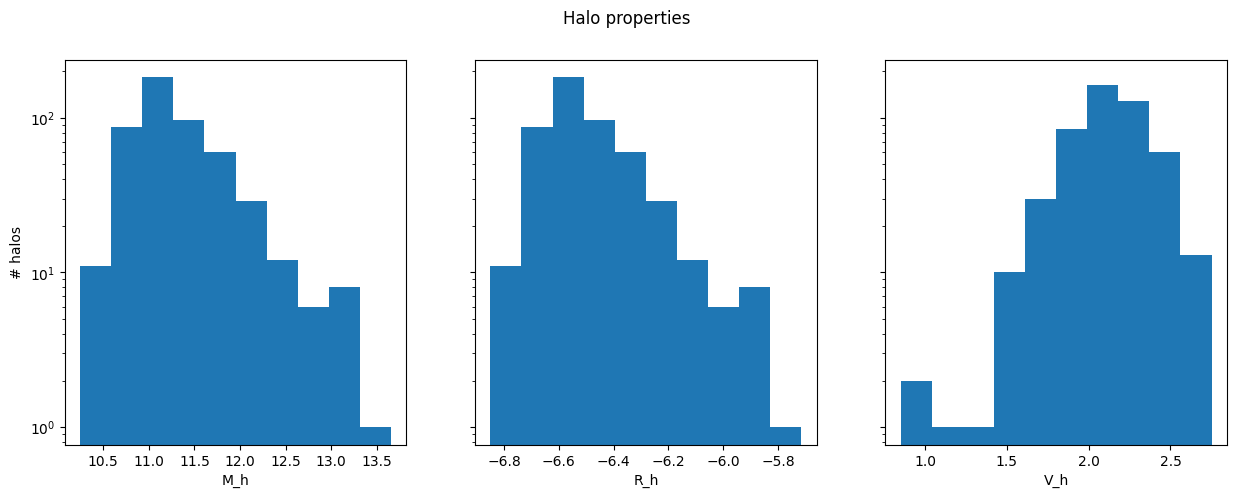

In [66]:
fig, axs = plt.subplots(1, 3, figsize = (15, 5), sharey = True, dpi = 100)

fig.suptitle('Halo properties')

axs[0].hist(df['M_h'])
axs[0].set_yscale('log')
axs[0].set_xlabel('M_h')
axs[0].set_ylabel('# halos')

axs[1].hist(df['R_h'])
axs[1].set_yscale('log')
axs[1].set_xlabel('R_h')

axs[2].hist(df['V_h'])
axs[2].set_yscale('log')
axs[2].set_xlabel('V_h')

And stellar mass as:

Text(0.5, 1.0, 'Galaxy properties')

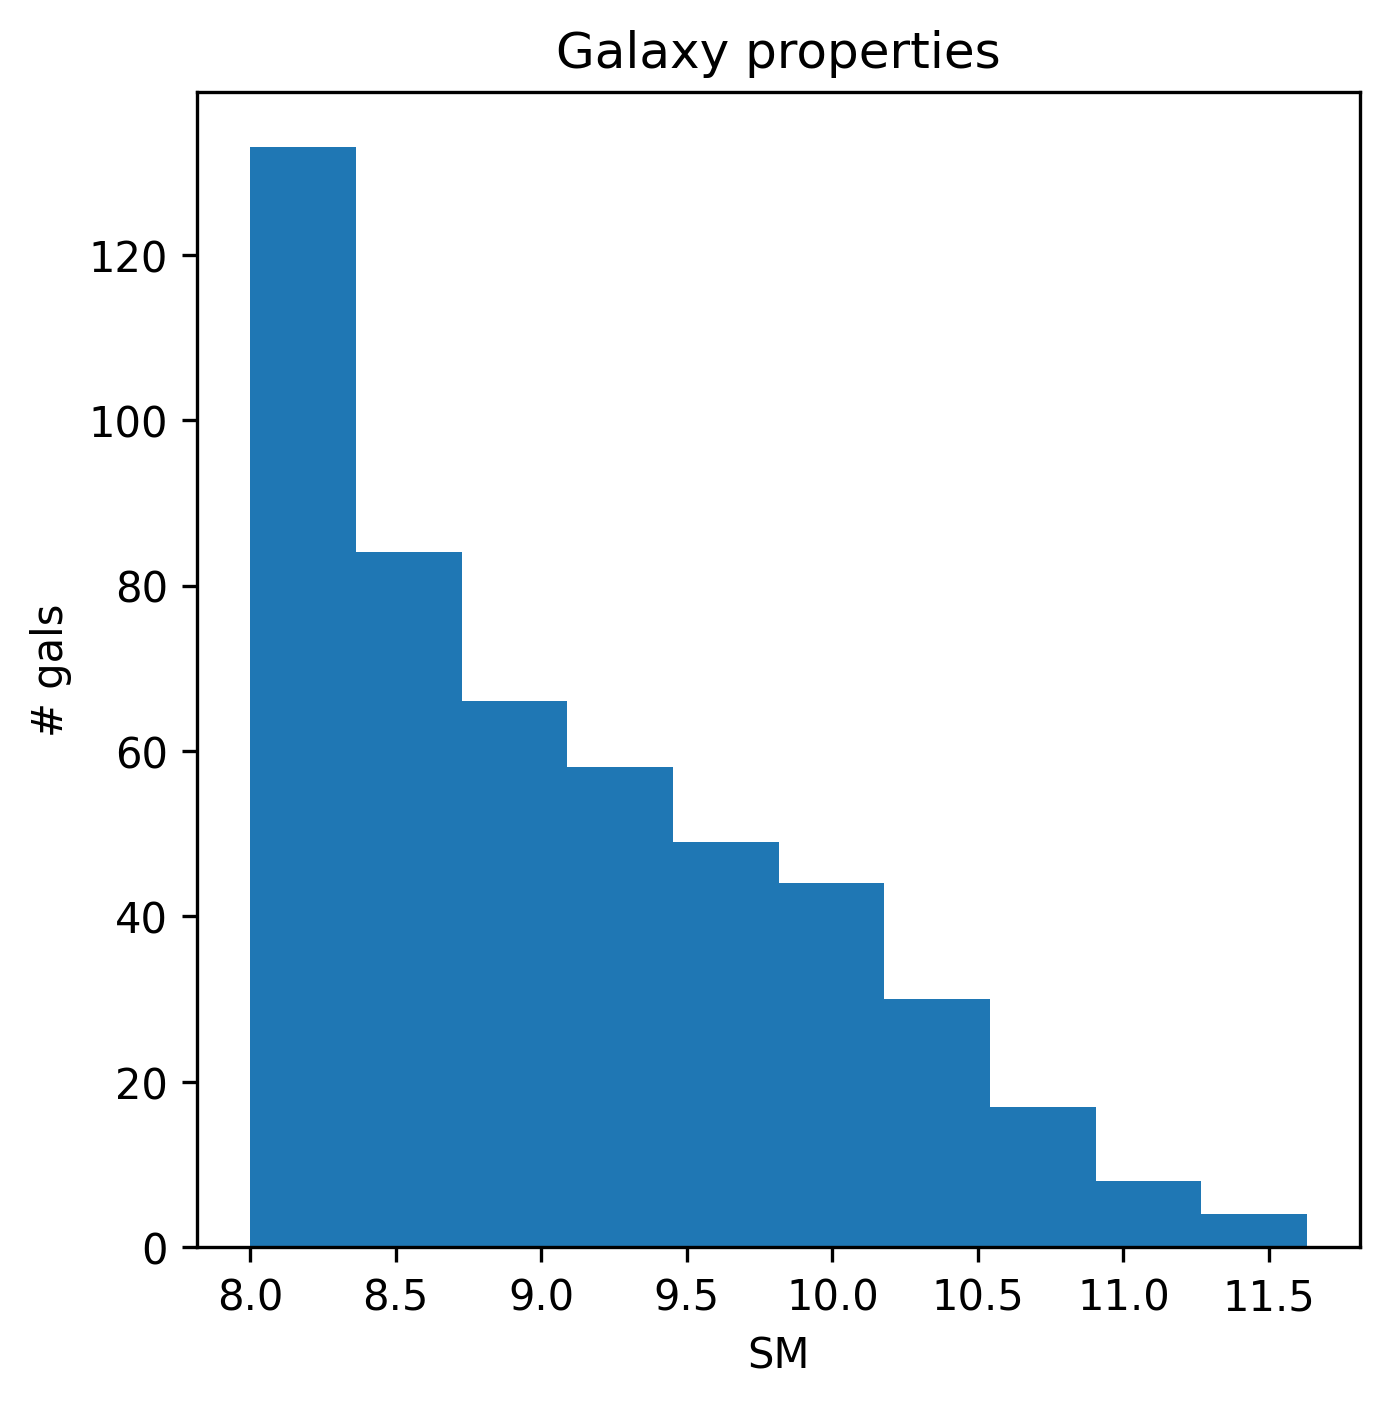

In [69]:
plt.figure(dpi = 300, figsize = (5, 5))
plt.hist(df['SM'])
plt.ylabel('# gals')
plt.xlabel('SM')
plt.title('Galaxy properties')

### 3.3) Measuring the correlation among halo/galaxy properties